## Semi Supervised General Adversarial Networks (SGANS)
(Making more iris data)

This notebook is intended to be a provide code for the hello work of SGANS. There are three feed foreward neural networks involved in training

#### Nerural Networks
+ Generator (nerual network) 
    + Noise Arrays In => Realistic Data Out

+ Discriminator (nerual network)
    + Real or Fake Data In => Classifcation Out, which category of iris (including a new category for fake ones)

+ Stacked Model: Generator + Discriminator(with weights frozen)
    + Noise Arrays In => Classifcation Out,  which category of iris (including a new category for fake ones)
    
#### Helper Functions
+ create_training_data: takes x,y and a generator => returns real_data, fake_data, labels 
+ training function trains the generator and distrciminator on a data set, using real and fake data

In [1]:
from __future__ import print_function, division
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import losses
from keras.utils import to_categorical
import keras.backend as K

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging

# base logger setup, to standardize logging across classes
try:
    logger.debug('testing logger')
except:
    name = 'SGAN'
    formatter = logging.Formatter(fmt='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO)
    logger.addHandler(handler)
    
# creates the generator (makes realistic data from noise)    
def create_generator(n_real_inputs, n_hidden_nodes, n_fake_inputs):
    inputs = Input(shape=[n_fake_inputs])
    dense_layer0 = Dense(n_hidden_nodes, kernel_initializer='glorot_normal')(inputs)
    norm0 = BatchNormalization()(dense_layer0)
    activation_layer0 = Activation('relu')(norm0)
    norm0 = BatchNormalization()(activation_layer0)
    outputs =  Dense(n_real_inputs, kernel_initializer='glorot_normal')(norm0) 
    generator = Model(inputs, outputs)
    generator.compile(loss='categorical_crossentropy', optimizer='adam')
    generator.trainable = True
    return generator

# create the discriminator to determine whether data is fake or real 
def create_discriminator(n_real_inputs, n_hidden_nodes, n_outputs, dropout_rate):
    inputs = Input(shape=[n_real_inputs])
    noise = GaussianNoise(.2)(inputs)
    dense_layer0 = Dense(n_hidden_nodes, kernel_initializer='glorot_normal')(noise)
    norm0 = BatchNormalization()(dense_layer0)
    activation_layer0 = Activation('relu')(norm0)
    dense_layer1 =  Dense(n_outputs + 1, kernel_initializer='glorot_normal')(activation_layer0) 
    outputs = Activation('sigmoid')(dense_layer1)
    discriminator  = Model(inputs, outputs)
    discriminator.compile(loss='categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])
    discriminator.trainable = True
    return discriminator

# Create a stacked version of the model with the generator wieghts frozen
def create_stacked_model(generator, discriminator):
    stacked_model = Sequential()
    generator.trainable = True
    discriminator.trainable = False
    stacked_model.add(generator)
    stacked_model.add(discriminator)
    stacked_model.compile(loss='categorical_crossentropy', optimizer='adam')
    return stacked_model

# define the training functions
def create_training_data(X_train, y_train, generator, batch=10):
    n_obs, n_inputs = X_train.shape
    half_batch = int(batch/2)
    n_fake_inputs = generator.get_input_shape_at(0)[1]
    
    # randomly sample real data 
    index =  np.random.randint(0, n_obs, half_batch)
    real_data = X_train[index, :]
    real_class_labels = y_train[index, :]
    
    # generate fake data 
    noise = np.random.normal(0, 1, (half_batch, n_fake_inputs))
    fake_data =  generator.predict(noise)
    
    # stack real and fake data 
    combined_data = np.concatenate((real_data, fake_data))
    
    #pad labels with zero rows
    labels_padded = np.vstack((real_class_labels, np.zeros(real_class_labels.shape)))
    logger.debug('labels padded shape {}'.format(labels_padded.shape))
    
    # create the real vs fake label
    real_fake_labels = np.reshape(np.append(np.zeros(half_batch), np.ones(half_batch)), (-1,1))
    logger.debug('real vs fake_labels {}'.format(real_fake_labels.shape))
    
    labels = np.hstack((labels_padded, real_fake_labels))
    
    logger.debug('real data shape {}'.format(real_data.shape))
    logger.debug('labels shape {}'.format(labels.shape))
    logger.debug('fake data shape {}'.format(fake_data.shape))

    return real_data, fake_data, labels 

# create miss labels that are used to forece the generator to import it's ability to make fakes 
def get_miss_labeled(noise):
    output = to_categorical(np.argmax(noise, axis=1))
    logger.debug(output.shape)
    return np.hstack((output, np.zeros((noise.shape[0], 1))))


# primary training functions
def training(X_train, y_train, generator, discriminator, epochs=10, batch=10):
    # create the stacked model
    stacked_model = create_stacked_model(generator, discriminator)
    
    # get the input data shape
    n_obs, n_inputs = X_train.shape
    half_batch = int(batch/2)
    n_fake_inputs = generator.get_input_shape_at(0)[1]
    n_outputs = y_train.shape[1]
    for e in range(epochs):
        real_data, fake_data, labels = create_training_data(X_train, y_train, generator, batch)
        combined_data = np.concatenate((real_data, fake_data))

        # discriminator loss 
        disc_loss = discriminator.train_on_batch(combined_data, labels)
        
        # create noise to 
        noise =  np.random.normal(0, 1, (batch, n_fake_inputs))
        
        # create misslabeled data to force the stack model to learn
        y_mislabled =  get_miss_labeled(noise)
    
        # genertor loss 
        gen_loss = stacked_model.train_on_batch(x=noise,y=y_mislabled)
        logger.info('epoch:{0}/{1}, disc_loss: {2}, gen_loss:{3}'.format(e, epochs, disc_loss, gen_loss))

    generator = stacked_model.layers[0]
    discriminator = stacked_model.layers[1]
    return generator, discriminator


C:\Python36\Lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Load data
This data set is good old fashion iris data, with three classes of iris to predict, the data comes packaged with sklearn

In [26]:
# load the X array (independent variables)
X_train = load_iris()['data']

# fit a scaler to normalize the data
scaler = StandardScaler().fit(X_train )

# transform the data so that is normalized
X = scaler.transform(X_train)

# load the labels
y = to_categorical(load_iris()['target'])  ## one hot encodes the integer classes 

# load the feature names
feature_names = load_iris()['feature_names'] 

# load the class catagories
class_names = list(load_iris()['target_names'])
logger.info('X shape {}'.format(X.shape))
logger.info('y shape {}'.format(y.shape))
print(class_names)

2019-10-08 11:14:41,454 - SGAN - INFO - X shape (150, 4)
2019-10-08 11:14:41,455 - SGAN - INFO - y shape (150, 3)


['setosa', 'versicolor', 'virginica']


#### Variables Setup
+ n_real_inputs numcols to input into the  generator
+ n_output num classes to predict (which category of iris)
+ n_fake_inputs used as inputs to the generator 
+ n_hidden_nodes number of hidden nodes in the generator and discrimitor

In [21]:
# setup inputs 
#num columns in input data
n_real_inputs = X.shape[1]

# number of class labels
n_outputs = y.shape[1]

# length of array used to generate examples
n_fake_inputs = n_outputs 

# number of hidden nodes in distriminator and generator
n_hidden_nodes = 20



#### Creating the Discriminator

The discriminators performs multi class classication to determine when the class label of the input data  is

+ an extract cateogory is added to number of classes, classifiying as fake
+ with the iris example, there are now ['setosa', 'versicolor', 'virginica', 'fake'] classes

In [22]:

# define discriminator
discriminator = create_discriminator(n_real_inputs, n_hidden_nodes, n_outputs, dropout_rate=.1 )
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
gaussian_noise_2 (GaussianNo (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                100       
_________________________________________________________________
batch_normalization_4 (Batch (None, 20)                80        
_________________________________________________________________
activation_4 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 84        
_________________________________________________________________
activation_5 (Activation)    (None, 4)                 0         
Total para

#### Creating the Generator
The generator takes arrays of random noise, this is created with numpy random normals. Also, misslabels are used to force the generator to get better at training fakes.  In this setup, the random normal array is the same size as the number of classication classes.  ArgMin is used to miss label the data, and a column is added to the labels (all zeros) indicating (wrongly) that the data is real.  
+ Generator is only training inside the stacked model using loss from the disriminator
+ wieghts of the disciminator are frozedn in the stacked model, so the missclassication error propigates back the the generator
+ Misslabeld data is used to force the generator to become better at making fake data


In [23]:
# define generator
generator = create_generator(n_real_inputs, n_hidden_nodes, n_fake_inputs)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                80        
_________________________________________________________________
batch_normalization_5 (Batch (None, 20)                80        
_________________________________________________________________
activation_6 (Activation)    (None, 20)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20)                80        
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 84        
Total params: 324
Trainable params: 244
Non-trainable params: 80
_________________________________________________________________


#### Creating the Stacked Model 
Only the discriminator and stacked model are trainined directly

In [5]:
stacked_model = create_stacked_model(generator, discriminator)
stacked_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 4)                 324       
_________________________________________________________________
model_2 (Model)              (None, 4)                 264       
Total params: 588
Trainable params: 244
Non-trainable params: 344
_________________________________________________________________


#### Example of Geneator imputs and MissLabeled Data
This demonstrates creating fake noise for input to the generator, as well as misslabel array to force the geneator (while inside the stacked model) to create better fakes

In [18]:

noise =  np.random.normal(0, 1, (5, 3))
print('random noise: \n', noise) 
print('miss labels: \n', get_miss_labeled(noise))

random noise: 
 [[ 1.99573004 -1.19664143 -1.37328321]
 [ 0.94309271 -0.64904304  0.61775045]
 [-0.66714374 -0.84123391  0.44192429]
 [-0.82861457  0.40995621 -0.34872563]
 [-0.85609429  0.85145277  2.04216836]]
miss labels: 
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]


### Example of Creating real and fake data
the create_training_data takes batch/2 samples from X and creates a batch/2 rows of fake data.  Each of these arrays are return, allong with a stacked version of the labels (correcly labeled) to train on the discriminator

In [6]:
## Test out the training creation Function
real_data, fake_data, labels = create_training_data(X, y, generator, batch=10)
pd.DataFrame(labels, columns =class_names + ['real_or_fake'])

,setosa,versicolor,virginica,real_or_fake
0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,0.0,0.0,1.0
6,0.0,0.0,0.0,1.0
7,0.0,0.0,0.0,1.0
8,0.0,0.0,0.0,1.0
9,0.0,0.0,0.0,1.0


#### Primary Training


In [7]:
generator, discriminator  = training(X, y, generator, discriminator,  epochs=1000, batch=125)

C:\Python36\Lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
2019-10-08 09:53:55,797 - SGAN - INFO - epoch:0/3000, disc_loss: [1.5611619, 0.41129032], gen_loss:1.723345160484314
2019-10-08 09:53:55,820 - SGAN - INFO - epoch:1/3000, disc_loss: [1.3617842, 0.32258064], gen_loss:1.71183443069458
2019-10-08 09:53:55,840 - SGAN - INFO - epoch:2/3000, disc_loss: [1.4279851, 0.2983871], gen_loss:1.6561074256896973
2019-10-08 09:53:55,860 - SGAN - INFO - epoch:3/3000, disc_loss: [1.4158769, 0.32258064], gen_loss:1.6426914930343628
2019-10-08 09:53:55,881 - SGAN - INFO - epoch:4/3000, disc_loss: [1.3848997, 0.33064517], gen_loss:1.681089162826538
2019-10-08 09:53:55,902 - SGAN - INFO - epoch:5/3000, disc_loss: [1.4013104, 0.28225806], gen_loss:1.6548445224761963
2019-10-08 09:53:

2019-10-08 09:53:57,217 - SGAN - INFO - epoch:68/3000, disc_loss: [1.1179053, 0.48387095], gen_loss:1.4828405380249023
2019-10-08 09:53:57,237 - SGAN - INFO - epoch:69/3000, disc_loss: [1.0902754, 0.4919355], gen_loss:1.4537242650985718
2019-10-08 09:53:57,258 - SGAN - INFO - epoch:70/3000, disc_loss: [1.108278, 0.5], gen_loss:1.4607079029083252
2019-10-08 09:53:57,279 - SGAN - INFO - epoch:71/3000, disc_loss: [1.1260998, 0.5], gen_loss:1.4942251443862915
2019-10-08 09:53:57,300 - SGAN - INFO - epoch:72/3000, disc_loss: [1.1688324, 0.47580644], gen_loss:1.4463647603988647
2019-10-08 09:53:57,321 - SGAN - INFO - epoch:73/3000, disc_loss: [1.1047672, 0.5], gen_loss:1.4522089958190918
2019-10-08 09:53:57,342 - SGAN - INFO - epoch:74/3000, disc_loss: [1.118304, 0.4919355], gen_loss:1.446812629699707
2019-10-08 09:53:57,363 - SGAN - INFO - epoch:75/3000, disc_loss: [1.0985409, 0.5241935], gen_loss:1.4297914505004883
2019-10-08 09:53:57,385 - SGAN - INFO - epoch:76/3000, disc_loss: [1.127917

2019-10-08 09:53:58,685 - SGAN - INFO - epoch:139/3000, disc_loss: [0.99010724, 0.516129], gen_loss:1.4808510541915894
2019-10-08 09:53:58,705 - SGAN - INFO - epoch:140/3000, disc_loss: [0.9545116, 0.5403226], gen_loss:1.4334348440170288
2019-10-08 09:53:58,726 - SGAN - INFO - epoch:141/3000, disc_loss: [0.94060487, 0.5564516], gen_loss:1.4300665855407715
2019-10-08 09:53:58,747 - SGAN - INFO - epoch:142/3000, disc_loss: [0.98571986, 0.5241935], gen_loss:1.4536635875701904
2019-10-08 09:53:58,768 - SGAN - INFO - epoch:143/3000, disc_loss: [0.9472382, 0.5322581], gen_loss:1.4591342210769653
2019-10-08 09:53:58,789 - SGAN - INFO - epoch:144/3000, disc_loss: [0.9170311, 0.58870965], gen_loss:1.4969245195388794
2019-10-08 09:53:58,809 - SGAN - INFO - epoch:145/3000, disc_loss: [0.949314, 0.5564516], gen_loss:1.4347965717315674
2019-10-08 09:53:58,830 - SGAN - INFO - epoch:146/3000, disc_loss: [0.95039994, 0.5483871], gen_loss:1.474975347518921
2019-10-08 09:53:58,851 - SGAN - INFO - epoch:

2019-10-08 09:54:00,064 - SGAN - INFO - epoch:208/3000, disc_loss: [0.8454543, 0.63709676], gen_loss:1.3991477489471436
2019-10-08 09:54:00,086 - SGAN - INFO - epoch:209/3000, disc_loss: [0.8534862, 0.6451613], gen_loss:1.3115859031677246
2019-10-08 09:54:00,106 - SGAN - INFO - epoch:210/3000, disc_loss: [0.93981373, 0.58064514], gen_loss:1.4113357067108154
2019-10-08 09:54:00,126 - SGAN - INFO - epoch:211/3000, disc_loss: [0.83849144, 0.62096775], gen_loss:1.364498496055603
2019-10-08 09:54:00,147 - SGAN - INFO - epoch:212/3000, disc_loss: [0.87433195, 0.5645161], gen_loss:1.3854249715805054
2019-10-08 09:54:00,168 - SGAN - INFO - epoch:213/3000, disc_loss: [0.88597333, 0.63709676], gen_loss:1.363500714302063
2019-10-08 09:54:00,189 - SGAN - INFO - epoch:214/3000, disc_loss: [0.8646356, 0.62903225], gen_loss:1.3581886291503906
2019-10-08 09:54:00,209 - SGAN - INFO - epoch:215/3000, disc_loss: [0.8297354, 0.5967742], gen_loss:1.3904638290405273
2019-10-08 09:54:00,230 - SGAN - INFO - e

2019-10-08 09:54:01,467 - SGAN - INFO - epoch:277/3000, disc_loss: [0.90810305, 0.5080645], gen_loss:1.1786442995071411
2019-10-08 09:54:01,486 - SGAN - INFO - epoch:278/3000, disc_loss: [0.8800085, 0.5322581], gen_loss:1.165692925453186
2019-10-08 09:54:01,506 - SGAN - INFO - epoch:279/3000, disc_loss: [0.8748688, 0.5645161], gen_loss:1.2492117881774902
2019-10-08 09:54:01,527 - SGAN - INFO - epoch:280/3000, disc_loss: [0.8912275, 0.5322581], gen_loss:1.137001872062683
2019-10-08 09:54:01,546 - SGAN - INFO - epoch:281/3000, disc_loss: [0.8813458, 0.5080645], gen_loss:1.2279983758926392
2019-10-08 09:54:01,566 - SGAN - INFO - epoch:282/3000, disc_loss: [0.9268683, 0.5322581], gen_loss:1.1900887489318848
2019-10-08 09:54:01,586 - SGAN - INFO - epoch:283/3000, disc_loss: [0.909355, 0.5403226], gen_loss:1.1866981983184814
2019-10-08 09:54:01,605 - SGAN - INFO - epoch:284/3000, disc_loss: [0.9306738, 0.47580644], gen_loss:1.1607911586761475
2019-10-08 09:54:01,625 - SGAN - INFO - epoch:285

2019-10-08 09:54:02,833 - SGAN - INFO - epoch:346/3000, disc_loss: [0.8798417, 0.6048387], gen_loss:1.1820728778839111
2019-10-08 09:54:02,852 - SGAN - INFO - epoch:347/3000, disc_loss: [0.92387736, 0.57258064], gen_loss:1.1128607988357544
2019-10-08 09:54:02,872 - SGAN - INFO - epoch:348/3000, disc_loss: [0.91559994, 0.6048387], gen_loss:1.1198756694793701
2019-10-08 09:54:02,892 - SGAN - INFO - epoch:349/3000, disc_loss: [0.9188724, 0.57258064], gen_loss:1.1405030488967896
2019-10-08 09:54:02,911 - SGAN - INFO - epoch:350/3000, disc_loss: [0.8900296, 0.5645161], gen_loss:1.160201072692871
2019-10-08 09:54:02,929 - SGAN - INFO - epoch:351/3000, disc_loss: [0.9284663, 0.5483871], gen_loss:1.1582974195480347
2019-10-08 09:54:02,949 - SGAN - INFO - epoch:352/3000, disc_loss: [0.9123651, 0.516129], gen_loss:1.1094118356704712
2019-10-08 09:54:02,969 - SGAN - INFO - epoch:353/3000, disc_loss: [0.871433, 0.61290324], gen_loss:1.1094564199447632
2019-10-08 09:54:02,990 - SGAN - INFO - epoch:

2019-10-08 09:54:04,216 - SGAN - INFO - epoch:415/3000, disc_loss: [0.8412951, 0.58064514], gen_loss:1.0919238328933716
2019-10-08 09:54:04,235 - SGAN - INFO - epoch:416/3000, disc_loss: [0.89514035, 0.516129], gen_loss:1.0684285163879395
2019-10-08 09:54:04,254 - SGAN - INFO - epoch:417/3000, disc_loss: [0.87575483, 0.516129], gen_loss:1.093666434288025
2019-10-08 09:54:04,274 - SGAN - INFO - epoch:418/3000, disc_loss: [0.8190657, 0.5564516], gen_loss:1.0673394203186035
2019-10-08 09:54:04,293 - SGAN - INFO - epoch:419/3000, disc_loss: [0.8471099, 0.5403226], gen_loss:1.1169968843460083
2019-10-08 09:54:04,313 - SGAN - INFO - epoch:420/3000, disc_loss: [0.8390685, 0.5322581], gen_loss:1.1266224384307861
2019-10-08 09:54:04,334 - SGAN - INFO - epoch:421/3000, disc_loss: [0.8495759, 0.58870965], gen_loss:1.0788235664367676
2019-10-08 09:54:04,353 - SGAN - INFO - epoch:422/3000, disc_loss: [0.82268804, 0.5645161], gen_loss:1.13003671169281
2019-10-08 09:54:04,373 - SGAN - INFO - epoch:42

2019-10-08 09:54:05,588 - SGAN - INFO - epoch:483/3000, disc_loss: [0.7982354, 0.5967742], gen_loss:1.0818332433700562
2019-10-08 09:54:05,609 - SGAN - INFO - epoch:484/3000, disc_loss: [0.8132483, 0.57258064], gen_loss:1.0867834091186523
2019-10-08 09:54:05,630 - SGAN - INFO - epoch:485/3000, disc_loss: [0.8480138, 0.5483871], gen_loss:1.0778690576553345
2019-10-08 09:54:05,650 - SGAN - INFO - epoch:486/3000, disc_loss: [0.8315988, 0.5], gen_loss:1.0825903415679932
2019-10-08 09:54:05,670 - SGAN - INFO - epoch:487/3000, disc_loss: [0.8224933, 0.5], gen_loss:1.0737035274505615
2019-10-08 09:54:05,691 - SGAN - INFO - epoch:488/3000, disc_loss: [0.81280357, 0.58870965], gen_loss:1.0358325242996216
2019-10-08 09:54:05,712 - SGAN - INFO - epoch:489/3000, disc_loss: [0.83180374, 0.5564516], gen_loss:1.082013726234436
2019-10-08 09:54:05,733 - SGAN - INFO - epoch:490/3000, disc_loss: [0.80018383, 0.62096775], gen_loss:1.0584821701049805
2019-10-08 09:54:05,752 - SGAN - INFO - epoch:491/3000,

2019-10-08 09:54:06,987 - SGAN - INFO - epoch:552/3000, disc_loss: [0.78970826, 0.58064514], gen_loss:1.0499274730682373
2019-10-08 09:54:07,006 - SGAN - INFO - epoch:553/3000, disc_loss: [0.80801016, 0.516129], gen_loss:1.0398370027542114
2019-10-08 09:54:07,026 - SGAN - INFO - epoch:554/3000, disc_loss: [0.7928215, 0.6048387], gen_loss:1.0910825729370117
2019-10-08 09:54:07,047 - SGAN - INFO - epoch:555/3000, disc_loss: [0.7609762, 0.5967742], gen_loss:1.0520364046096802
2019-10-08 09:54:07,070 - SGAN - INFO - epoch:556/3000, disc_loss: [0.7549443, 0.61290324], gen_loss:1.054959774017334
2019-10-08 09:54:07,090 - SGAN - INFO - epoch:557/3000, disc_loss: [0.8048765, 0.5564516], gen_loss:1.0316532850265503
2019-10-08 09:54:07,113 - SGAN - INFO - epoch:558/3000, disc_loss: [0.76830375, 0.57258064], gen_loss:1.1180946826934814
2019-10-08 09:54:07,132 - SGAN - INFO - epoch:559/3000, disc_loss: [0.7539678, 0.6532258], gen_loss:1.0173169374465942
2019-10-08 09:54:07,151 - SGAN - INFO - epoc

2019-10-08 09:54:08,403 - SGAN - INFO - epoch:621/3000, disc_loss: [0.74825966, 0.58870965], gen_loss:1.0283944606781006
2019-10-08 09:54:08,423 - SGAN - INFO - epoch:622/3000, disc_loss: [0.69982374, 0.67741936], gen_loss:1.0885101556777954
2019-10-08 09:54:08,443 - SGAN - INFO - epoch:623/3000, disc_loss: [0.75355864, 0.63709676], gen_loss:1.0518146753311157
2019-10-08 09:54:08,463 - SGAN - INFO - epoch:624/3000, disc_loss: [0.7558871, 0.5967742], gen_loss:1.0624377727508545
2019-10-08 09:54:08,484 - SGAN - INFO - epoch:625/3000, disc_loss: [0.75206256, 0.6451613], gen_loss:1.0748339891433716
2019-10-08 09:54:08,502 - SGAN - INFO - epoch:626/3000, disc_loss: [0.7808139, 0.61290324], gen_loss:1.0425225496292114
2019-10-08 09:54:08,521 - SGAN - INFO - epoch:627/3000, disc_loss: [0.7811359, 0.61290324], gen_loss:1.0463730096817017
2019-10-08 09:54:08,541 - SGAN - INFO - epoch:628/3000, disc_loss: [0.76360077, 0.5967742], gen_loss:1.0774058103561401
2019-10-08 09:54:08,561 - SGAN - INFO 

2019-10-08 09:54:09,775 - SGAN - INFO - epoch:690/3000, disc_loss: [0.8269043, 0.57258064], gen_loss:1.0441858768463135
2019-10-08 09:54:09,795 - SGAN - INFO - epoch:691/3000, disc_loss: [0.8094153, 0.5645161], gen_loss:1.0457781553268433
2019-10-08 09:54:09,815 - SGAN - INFO - epoch:692/3000, disc_loss: [0.72791684, 0.6532258], gen_loss:1.2620654106140137
2019-10-08 09:54:09,835 - SGAN - INFO - epoch:693/3000, disc_loss: [0.72994405, 0.6451613], gen_loss:0.9903225302696228
2019-10-08 09:54:09,855 - SGAN - INFO - epoch:694/3000, disc_loss: [0.7657666, 0.62903225], gen_loss:1.0859626531600952
2019-10-08 09:54:09,876 - SGAN - INFO - epoch:695/3000, disc_loss: [0.7549647, 0.5645161], gen_loss:1.0681331157684326
2019-10-08 09:54:09,897 - SGAN - INFO - epoch:696/3000, disc_loss: [0.76790076, 0.5080645], gen_loss:1.0673877000808716
2019-10-08 09:54:09,917 - SGAN - INFO - epoch:697/3000, disc_loss: [0.77123076, 0.5403226], gen_loss:0.9989811778068542
2019-10-08 09:54:09,937 - SGAN - INFO - ep

2019-10-08 09:54:11,165 - SGAN - INFO - epoch:759/3000, disc_loss: [0.68900627, 0.66935486], gen_loss:1.00803542137146
2019-10-08 09:54:11,186 - SGAN - INFO - epoch:760/3000, disc_loss: [0.7586313, 0.62903225], gen_loss:0.994795560836792
2019-10-08 09:54:11,206 - SGAN - INFO - epoch:761/3000, disc_loss: [0.69950503, 0.6451613], gen_loss:1.0821771621704102
2019-10-08 09:54:11,226 - SGAN - INFO - epoch:762/3000, disc_loss: [0.75122845, 0.6048387], gen_loss:0.9704107046127319
2019-10-08 09:54:11,247 - SGAN - INFO - epoch:763/3000, disc_loss: [0.71237934, 0.6935484], gen_loss:1.0488369464874268
2019-10-08 09:54:11,266 - SGAN - INFO - epoch:764/3000, disc_loss: [0.6822265, 0.58870965], gen_loss:1.0308444499969482
2019-10-08 09:54:11,286 - SGAN - INFO - epoch:765/3000, disc_loss: [0.70148814, 0.6532258], gen_loss:0.9899206757545471
2019-10-08 09:54:11,307 - SGAN - INFO - epoch:766/3000, disc_loss: [0.7195416, 0.6451613], gen_loss:1.0988432168960571
2019-10-08 09:54:11,326 - SGAN - INFO - epo

2019-10-08 09:54:12,571 - SGAN - INFO - epoch:828/3000, disc_loss: [0.65659523, 0.66935486], gen_loss:1.0345298051834106
2019-10-08 09:54:12,592 - SGAN - INFO - epoch:829/3000, disc_loss: [0.69383425, 0.7096774], gen_loss:0.9824840426445007
2019-10-08 09:54:12,611 - SGAN - INFO - epoch:830/3000, disc_loss: [0.6969717, 0.62903225], gen_loss:1.0641590356826782
2019-10-08 09:54:12,631 - SGAN - INFO - epoch:831/3000, disc_loss: [0.75098944, 0.58870965], gen_loss:1.085644006729126
2019-10-08 09:54:12,652 - SGAN - INFO - epoch:832/3000, disc_loss: [0.6866396, 0.66129035], gen_loss:1.1000568866729736
2019-10-08 09:54:12,672 - SGAN - INFO - epoch:833/3000, disc_loss: [0.6798433, 0.6451613], gen_loss:1.0302566289901733
2019-10-08 09:54:12,692 - SGAN - INFO - epoch:834/3000, disc_loss: [0.6592746, 0.7096774], gen_loss:0.9175822734832764
2019-10-08 09:54:12,712 - SGAN - INFO - epoch:835/3000, disc_loss: [0.6981471, 0.67741936], gen_loss:0.9944373965263367
2019-10-08 09:54:12,732 - SGAN - INFO - e

2019-10-08 09:54:13,976 - SGAN - INFO - epoch:897/3000, disc_loss: [0.7657142, 0.5322581], gen_loss:1.0942881107330322
2019-10-08 09:54:13,995 - SGAN - INFO - epoch:898/3000, disc_loss: [0.75758415, 0.5967742], gen_loss:1.1125937700271606
2019-10-08 09:54:14,015 - SGAN - INFO - epoch:899/3000, disc_loss: [0.74223083, 0.58064514], gen_loss:0.9749267101287842
2019-10-08 09:54:14,035 - SGAN - INFO - epoch:900/3000, disc_loss: [0.6644519, 0.66129035], gen_loss:0.9641247987747192
2019-10-08 09:54:14,054 - SGAN - INFO - epoch:901/3000, disc_loss: [0.7237645, 0.61290324], gen_loss:1.0058752298355103
2019-10-08 09:54:14,075 - SGAN - INFO - epoch:902/3000, disc_loss: [0.7317046, 0.6048387], gen_loss:1.0692555904388428
2019-10-08 09:54:14,095 - SGAN - INFO - epoch:903/3000, disc_loss: [0.72553134, 0.66129035], gen_loss:0.9814045429229736
2019-10-08 09:54:14,114 - SGAN - INFO - epoch:904/3000, disc_loss: [0.72487444, 0.7258065], gen_loss:1.0281941890716553
2019-10-08 09:54:14,135 - SGAN - INFO - 

2019-10-08 09:54:15,351 - SGAN - INFO - epoch:966/3000, disc_loss: [0.78175807, 0.58064514], gen_loss:1.1077324151992798
2019-10-08 09:54:15,370 - SGAN - INFO - epoch:967/3000, disc_loss: [0.6504381, 0.66935486], gen_loss:1.095170021057129
2019-10-08 09:54:15,390 - SGAN - INFO - epoch:968/3000, disc_loss: [0.6883825, 0.62903225], gen_loss:1.0643585920333862
2019-10-08 09:54:15,410 - SGAN - INFO - epoch:969/3000, disc_loss: [0.6393439, 0.733871], gen_loss:1.004530906677246
2019-10-08 09:54:15,430 - SGAN - INFO - epoch:970/3000, disc_loss: [0.7223826, 0.67741936], gen_loss:1.0887254476547241
2019-10-08 09:54:15,450 - SGAN - INFO - epoch:971/3000, disc_loss: [0.7528034, 0.6451613], gen_loss:1.0378520488739014
2019-10-08 09:54:15,470 - SGAN - INFO - epoch:972/3000, disc_loss: [0.69822246, 0.66129035], gen_loss:0.9336817264556885
2019-10-08 09:54:15,490 - SGAN - INFO - epoch:973/3000, disc_loss: [0.66615987, 0.6935484], gen_loss:1.1522375345230103
2019-10-08 09:54:15,509 - SGAN - INFO - epo

2019-10-08 09:54:16,731 - SGAN - INFO - epoch:1035/3000, disc_loss: [0.7614219, 0.6935484], gen_loss:1.0721747875213623
2019-10-08 09:54:16,751 - SGAN - INFO - epoch:1036/3000, disc_loss: [0.6271928, 0.766129], gen_loss:0.9840522408485413
2019-10-08 09:54:16,770 - SGAN - INFO - epoch:1037/3000, disc_loss: [0.76481307, 0.63709676], gen_loss:0.9776978492736816
2019-10-08 09:54:16,790 - SGAN - INFO - epoch:1038/3000, disc_loss: [0.64887404, 0.7741935], gen_loss:1.179538369178772
2019-10-08 09:54:16,809 - SGAN - INFO - epoch:1039/3000, disc_loss: [0.68923193, 0.7177419], gen_loss:1.137149453163147
2019-10-08 09:54:16,829 - SGAN - INFO - epoch:1040/3000, disc_loss: [0.6110864, 0.7419355], gen_loss:1.2020376920700073
2019-10-08 09:54:16,849 - SGAN - INFO - epoch:1041/3000, disc_loss: [0.67191935, 0.7580645], gen_loss:1.0353937149047852
2019-10-08 09:54:16,869 - SGAN - INFO - epoch:1042/3000, disc_loss: [0.66734016, 0.733871], gen_loss:1.004744052886963
2019-10-08 09:54:16,890 - SGAN - INFO -

2019-10-08 09:54:18,105 - SGAN - INFO - epoch:1104/3000, disc_loss: [0.67055374, 0.67741936], gen_loss:1.203111171722412
2019-10-08 09:54:18,124 - SGAN - INFO - epoch:1105/3000, disc_loss: [0.6125411, 0.6935484], gen_loss:1.2524747848510742
2019-10-08 09:54:18,145 - SGAN - INFO - epoch:1106/3000, disc_loss: [0.693936, 0.6532258], gen_loss:1.3062434196472168
2019-10-08 09:54:18,165 - SGAN - INFO - epoch:1107/3000, disc_loss: [0.6943329, 0.6451613], gen_loss:1.3235167264938354
2019-10-08 09:54:18,185 - SGAN - INFO - epoch:1108/3000, disc_loss: [0.8032074, 0.5241935], gen_loss:1.2331184148788452
2019-10-08 09:54:18,205 - SGAN - INFO - epoch:1109/3000, disc_loss: [0.6734506, 0.6532258], gen_loss:1.3546380996704102
2019-10-08 09:54:18,224 - SGAN - INFO - epoch:1110/3000, disc_loss: [0.68504, 0.7258065], gen_loss:1.2668323516845703
2019-10-08 09:54:18,245 - SGAN - INFO - epoch:1111/3000, disc_loss: [0.7204901, 0.58870965], gen_loss:1.2519936561584473
2019-10-08 09:54:18,265 - SGAN - INFO - e

2019-10-08 09:54:19,487 - SGAN - INFO - epoch:1173/3000, disc_loss: [0.68269014, 0.6532258], gen_loss:1.2003422975540161
2019-10-08 09:54:19,507 - SGAN - INFO - epoch:1174/3000, disc_loss: [0.697106, 0.6854839], gen_loss:1.2690738439559937
2019-10-08 09:54:19,527 - SGAN - INFO - epoch:1175/3000, disc_loss: [0.7046682, 0.58064514], gen_loss:1.2355905771255493
2019-10-08 09:54:19,548 - SGAN - INFO - epoch:1176/3000, disc_loss: [0.68085593, 0.66935486], gen_loss:1.2026201486587524
2019-10-08 09:54:19,568 - SGAN - INFO - epoch:1177/3000, disc_loss: [0.7077839, 0.6048387], gen_loss:1.2748713493347168
2019-10-08 09:54:19,587 - SGAN - INFO - epoch:1178/3000, disc_loss: [0.73428196, 0.62903225], gen_loss:1.0891352891921997
2019-10-08 09:54:19,607 - SGAN - INFO - epoch:1179/3000, disc_loss: [0.7427363, 0.58064514], gen_loss:1.0872348546981812
2019-10-08 09:54:19,627 - SGAN - INFO - epoch:1180/3000, disc_loss: [0.7298527, 0.62903225], gen_loss:1.1485801935195923
2019-10-08 09:54:19,647 - SGAN - 

2019-10-08 09:54:20,856 - SGAN - INFO - epoch:1241/3000, disc_loss: [0.6950435, 0.62903225], gen_loss:1.1434850692749023
2019-10-08 09:54:20,876 - SGAN - INFO - epoch:1242/3000, disc_loss: [0.67929643, 0.733871], gen_loss:1.0823322534561157
2019-10-08 09:54:20,898 - SGAN - INFO - epoch:1243/3000, disc_loss: [0.62679756, 0.6854839], gen_loss:1.09029221534729
2019-10-08 09:54:20,917 - SGAN - INFO - epoch:1244/3000, disc_loss: [0.69683826, 0.6854839], gen_loss:1.3789558410644531
2019-10-08 09:54:20,937 - SGAN - INFO - epoch:1245/3000, disc_loss: [0.71534467, 0.62903225], gen_loss:1.274767279624939
2019-10-08 09:54:20,957 - SGAN - INFO - epoch:1246/3000, disc_loss: [0.69303375, 0.6532258], gen_loss:1.2244635820388794
2019-10-08 09:54:20,978 - SGAN - INFO - epoch:1247/3000, disc_loss: [0.6670875, 0.62096775], gen_loss:1.2137097120285034
2019-10-08 09:54:20,998 - SGAN - INFO - epoch:1248/3000, disc_loss: [0.6121669, 0.7741935], gen_loss:1.1601150035858154
2019-10-08 09:54:21,018 - SGAN - INF

2019-10-08 09:54:22,243 - SGAN - INFO - epoch:1310/3000, disc_loss: [0.6168075, 0.75], gen_loss:1.1003590822219849
2019-10-08 09:54:22,263 - SGAN - INFO - epoch:1311/3000, disc_loss: [0.5980256, 0.7258065], gen_loss:1.1192142963409424
2019-10-08 09:54:22,284 - SGAN - INFO - epoch:1312/3000, disc_loss: [0.6676363, 0.62096775], gen_loss:1.1925878524780273
2019-10-08 09:54:22,305 - SGAN - INFO - epoch:1313/3000, disc_loss: [0.6784977, 0.62903225], gen_loss:1.073235273361206
2019-10-08 09:54:22,324 - SGAN - INFO - epoch:1314/3000, disc_loss: [0.6604589, 0.66935486], gen_loss:1.0766091346740723
2019-10-08 09:54:22,343 - SGAN - INFO - epoch:1315/3000, disc_loss: [0.6738533, 0.6532258], gen_loss:1.026317834854126
2019-10-08 09:54:22,364 - SGAN - INFO - epoch:1316/3000, disc_loss: [0.71280587, 0.66935486], gen_loss:1.0929837226867676
2019-10-08 09:54:22,384 - SGAN - INFO - epoch:1317/3000, disc_loss: [0.5651886, 0.7741935], gen_loss:1.0671485662460327
2019-10-08 09:54:22,405 - SGAN - INFO - ep

2019-10-08 09:54:23,623 - SGAN - INFO - epoch:1379/3000, disc_loss: [0.59616715, 0.75], gen_loss:1.2094509601593018
2019-10-08 09:54:23,642 - SGAN - INFO - epoch:1380/3000, disc_loss: [0.6340821, 0.7016129], gen_loss:1.143457293510437
2019-10-08 09:54:23,663 - SGAN - INFO - epoch:1381/3000, disc_loss: [0.65533817, 0.733871], gen_loss:1.264154076576233
2019-10-08 09:54:23,683 - SGAN - INFO - epoch:1382/3000, disc_loss: [0.6579157, 0.7096774], gen_loss:1.0626581907272339
2019-10-08 09:54:23,703 - SGAN - INFO - epoch:1383/3000, disc_loss: [0.6308035, 0.7258065], gen_loss:1.0154246091842651
2019-10-08 09:54:23,723 - SGAN - INFO - epoch:1384/3000, disc_loss: [0.6911011, 0.6532258], gen_loss:1.011863112449646
2019-10-08 09:54:23,744 - SGAN - INFO - epoch:1385/3000, disc_loss: [0.65232253, 0.63709676], gen_loss:1.032251000404358
2019-10-08 09:54:23,764 - SGAN - INFO - epoch:1386/3000, disc_loss: [0.77284425, 0.58870965], gen_loss:1.0626318454742432
2019-10-08 09:54:23,784 - SGAN - INFO - epoc

2019-10-08 09:54:25,013 - SGAN - INFO - epoch:1448/3000, disc_loss: [0.59732884, 0.7580645], gen_loss:1.1837877035140991
2019-10-08 09:54:25,032 - SGAN - INFO - epoch:1449/3000, disc_loss: [0.5943013, 0.8145161], gen_loss:1.081800103187561
2019-10-08 09:54:25,051 - SGAN - INFO - epoch:1450/3000, disc_loss: [0.6349346, 0.7016129], gen_loss:0.9572559595108032
2019-10-08 09:54:25,071 - SGAN - INFO - epoch:1451/3000, disc_loss: [0.5854152, 0.75], gen_loss:1.3839634656906128
2019-10-08 09:54:25,092 - SGAN - INFO - epoch:1452/3000, disc_loss: [0.6245472, 0.7580645], gen_loss:1.0569998025894165
2019-10-08 09:54:25,112 - SGAN - INFO - epoch:1453/3000, disc_loss: [0.5373889, 0.7741935], gen_loss:1.0607272386550903
2019-10-08 09:54:25,131 - SGAN - INFO - epoch:1454/3000, disc_loss: [0.553553, 0.7419355], gen_loss:0.9550354480743408
2019-10-08 09:54:25,152 - SGAN - INFO - epoch:1455/3000, disc_loss: [0.52161187, 0.8064516], gen_loss:1.1489827632904053
2019-10-08 09:54:25,172 - SGAN - INFO - epoch

2019-10-08 09:54:26,389 - SGAN - INFO - epoch:1517/3000, disc_loss: [0.5989234, 0.75], gen_loss:1.1034014225006104
2019-10-08 09:54:26,410 - SGAN - INFO - epoch:1518/3000, disc_loss: [0.5799068, 0.733871], gen_loss:1.348941445350647
2019-10-08 09:54:26,430 - SGAN - INFO - epoch:1519/3000, disc_loss: [0.58916956, 0.7419355], gen_loss:1.2337520122528076
2019-10-08 09:54:26,450 - SGAN - INFO - epoch:1520/3000, disc_loss: [0.60098594, 0.7419355], gen_loss:1.8475532531738281
2019-10-08 09:54:26,469 - SGAN - INFO - epoch:1521/3000, disc_loss: [0.6011601, 0.7096774], gen_loss:1.2699223756790161
2019-10-08 09:54:26,490 - SGAN - INFO - epoch:1522/3000, disc_loss: [0.5556025, 0.7580645], gen_loss:1.195535659790039
2019-10-08 09:54:26,511 - SGAN - INFO - epoch:1523/3000, disc_loss: [0.61253136, 0.7177419], gen_loss:1.0742193460464478
2019-10-08 09:54:26,531 - SGAN - INFO - epoch:1524/3000, disc_loss: [0.5614272, 0.7822581], gen_loss:1.194146752357483
2019-10-08 09:54:26,551 - SGAN - INFO - epoch:

2019-10-08 09:54:27,780 - SGAN - INFO - epoch:1586/3000, disc_loss: [0.6517642, 0.7177419], gen_loss:1.1322089433670044
2019-10-08 09:54:27,800 - SGAN - INFO - epoch:1587/3000, disc_loss: [0.5541221, 0.7822581], gen_loss:1.008022665977478
2019-10-08 09:54:27,820 - SGAN - INFO - epoch:1588/3000, disc_loss: [0.5544094, 0.7983871], gen_loss:1.0908459424972534
2019-10-08 09:54:27,841 - SGAN - INFO - epoch:1589/3000, disc_loss: [0.621012, 0.7016129], gen_loss:0.9411029815673828
2019-10-08 09:54:27,862 - SGAN - INFO - epoch:1590/3000, disc_loss: [0.5992809, 0.7580645], gen_loss:1.0151910781860352
2019-10-08 09:54:27,881 - SGAN - INFO - epoch:1591/3000, disc_loss: [0.61730367, 0.7016129], gen_loss:1.0882995128631592
2019-10-08 09:54:27,901 - SGAN - INFO - epoch:1592/3000, disc_loss: [0.55242145, 0.7580645], gen_loss:1.3932161331176758
2019-10-08 09:54:27,921 - SGAN - INFO - epoch:1593/3000, disc_loss: [0.5006616, 0.8145161], gen_loss:1.1044294834136963
2019-10-08 09:54:27,941 - SGAN - INFO - 

2019-10-08 09:54:29,160 - SGAN - INFO - epoch:1655/3000, disc_loss: [0.5925265, 0.7741935], gen_loss:1.058583378791809
2019-10-08 09:54:29,179 - SGAN - INFO - epoch:1656/3000, disc_loss: [0.65866876, 0.7258065], gen_loss:1.0976521968841553
2019-10-08 09:54:29,200 - SGAN - INFO - epoch:1657/3000, disc_loss: [0.6016704, 0.7096774], gen_loss:1.0528684854507446
2019-10-08 09:54:29,219 - SGAN - INFO - epoch:1658/3000, disc_loss: [0.59746355, 0.7983871], gen_loss:1.103365182876587
2019-10-08 09:54:29,240 - SGAN - INFO - epoch:1659/3000, disc_loss: [0.56852007, 0.7741935], gen_loss:1.0853406190872192
2019-10-08 09:54:29,260 - SGAN - INFO - epoch:1660/3000, disc_loss: [0.59017, 0.7258065], gen_loss:1.080096960067749
2019-10-08 09:54:29,281 - SGAN - INFO - epoch:1661/3000, disc_loss: [0.5784645, 0.766129], gen_loss:1.108539342880249
2019-10-08 09:54:29,301 - SGAN - INFO - epoch:1662/3000, disc_loss: [0.5250184, 0.7903226], gen_loss:1.1904146671295166
2019-10-08 09:54:29,321 - SGAN - INFO - epoc

2019-10-08 09:54:30,554 - SGAN - INFO - epoch:1724/3000, disc_loss: [0.59680575, 0.7258065], gen_loss:1.0188851356506348
2019-10-08 09:54:30,575 - SGAN - INFO - epoch:1725/3000, disc_loss: [0.5589107, 0.7822581], gen_loss:1.0496010780334473
2019-10-08 09:54:30,595 - SGAN - INFO - epoch:1726/3000, disc_loss: [0.54187006, 0.7903226], gen_loss:1.1219244003295898
2019-10-08 09:54:30,615 - SGAN - INFO - epoch:1727/3000, disc_loss: [0.5188009, 0.82258064], gen_loss:1.2794780731201172
2019-10-08 09:54:30,635 - SGAN - INFO - epoch:1728/3000, disc_loss: [0.56781584, 0.7741935], gen_loss:1.0021111965179443
2019-10-08 09:54:30,655 - SGAN - INFO - epoch:1729/3000, disc_loss: [0.46501136, 0.83064514], gen_loss:1.1344255208969116
2019-10-08 09:54:30,675 - SGAN - INFO - epoch:1730/3000, disc_loss: [0.52179086, 0.7580645], gen_loss:1.1248805522918701
2019-10-08 09:54:30,695 - SGAN - INFO - epoch:1731/3000, disc_loss: [0.5409872, 0.7983871], gen_loss:1.0392868518829346
2019-10-08 09:54:30,717 - SGAN - 

2019-10-08 09:54:31,933 - SGAN - INFO - epoch:1793/3000, disc_loss: [0.57436574, 0.7419355], gen_loss:1.0476195812225342
2019-10-08 09:54:31,953 - SGAN - INFO - epoch:1794/3000, disc_loss: [0.6544235, 0.7419355], gen_loss:0.9533607363700867
2019-10-08 09:54:31,973 - SGAN - INFO - epoch:1795/3000, disc_loss: [0.40769482, 0.8467742], gen_loss:1.1053996086120605
2019-10-08 09:54:31,992 - SGAN - INFO - epoch:1796/3000, disc_loss: [0.57813126, 0.75], gen_loss:1.1933048963546753
2019-10-08 09:54:32,012 - SGAN - INFO - epoch:1797/3000, disc_loss: [0.61981773, 0.7016129], gen_loss:1.1814677715301514
2019-10-08 09:54:32,033 - SGAN - INFO - epoch:1798/3000, disc_loss: [0.45383677, 0.82258064], gen_loss:1.1339309215545654
2019-10-08 09:54:32,053 - SGAN - INFO - epoch:1799/3000, disc_loss: [0.599028, 0.7016129], gen_loss:1.0703001022338867
2019-10-08 09:54:32,073 - SGAN - INFO - epoch:1800/3000, disc_loss: [0.56235504, 0.7903226], gen_loss:0.9908521771430969
2019-10-08 09:54:32,093 - SGAN - INFO -

2019-10-08 09:54:33,324 - SGAN - INFO - epoch:1862/3000, disc_loss: [0.49320775, 0.83870965], gen_loss:0.9361910223960876
2019-10-08 09:54:33,343 - SGAN - INFO - epoch:1863/3000, disc_loss: [0.57789207, 0.7903226], gen_loss:1.230228066444397
2019-10-08 09:54:33,363 - SGAN - INFO - epoch:1864/3000, disc_loss: [0.6559865, 0.7096774], gen_loss:1.230062484741211
2019-10-08 09:54:33,383 - SGAN - INFO - epoch:1865/3000, disc_loss: [0.65600246, 0.733871], gen_loss:1.1606491804122925
2019-10-08 09:54:33,403 - SGAN - INFO - epoch:1866/3000, disc_loss: [0.62761694, 0.7177419], gen_loss:1.0246778726577759
2019-10-08 09:54:33,423 - SGAN - INFO - epoch:1867/3000, disc_loss: [0.592573, 0.7419355], gen_loss:0.9510906338691711
2019-10-08 09:54:33,443 - SGAN - INFO - epoch:1868/3000, disc_loss: [0.6046614, 0.7096774], gen_loss:1.231562614440918
2019-10-08 09:54:33,463 - SGAN - INFO - epoch:1869/3000, disc_loss: [0.62342584, 0.7258065], gen_loss:1.215628981590271
2019-10-08 09:54:33,483 - SGAN - INFO - 

2019-10-08 09:54:34,706 - SGAN - INFO - epoch:1931/3000, disc_loss: [0.71364415, 0.61290324], gen_loss:1.321123480796814
2019-10-08 09:54:34,725 - SGAN - INFO - epoch:1932/3000, disc_loss: [0.63948673, 0.62096775], gen_loss:1.296741008758545
2019-10-08 09:54:34,745 - SGAN - INFO - epoch:1933/3000, disc_loss: [0.6150916, 0.7177419], gen_loss:1.0345721244812012
2019-10-08 09:54:34,765 - SGAN - INFO - epoch:1934/3000, disc_loss: [0.56802416, 0.766129], gen_loss:1.1715307235717773
2019-10-08 09:54:34,785 - SGAN - INFO - epoch:1935/3000, disc_loss: [0.6380805, 0.67741936], gen_loss:1.1187862157821655
2019-10-08 09:54:34,805 - SGAN - INFO - epoch:1936/3000, disc_loss: [0.69144785, 0.6532258], gen_loss:1.0548454523086548
2019-10-08 09:54:34,825 - SGAN - INFO - epoch:1937/3000, disc_loss: [0.6612825, 0.67741936], gen_loss:1.2008293867111206
2019-10-08 09:54:34,847 - SGAN - INFO - epoch:1938/3000, disc_loss: [0.53961915, 0.7419355], gen_loss:1.1020903587341309
2019-10-08 09:54:34,867 - SGAN - I

2019-10-08 09:54:36,099 - SGAN - INFO - epoch:2000/3000, disc_loss: [0.6319683, 0.6854839], gen_loss:1.2145655155181885
2019-10-08 09:54:36,120 - SGAN - INFO - epoch:2001/3000, disc_loss: [0.5994781, 0.7096774], gen_loss:1.1498039960861206
2019-10-08 09:54:36,141 - SGAN - INFO - epoch:2002/3000, disc_loss: [0.68381834, 0.62903225], gen_loss:1.0623308420181274
2019-10-08 09:54:36,160 - SGAN - INFO - epoch:2003/3000, disc_loss: [0.68124855, 0.6532258], gen_loss:1.2850658893585205
2019-10-08 09:54:36,180 - SGAN - INFO - epoch:2004/3000, disc_loss: [0.711038, 0.6854839], gen_loss:1.1487127542495728
2019-10-08 09:54:36,200 - SGAN - INFO - epoch:2005/3000, disc_loss: [0.55122024, 0.7580645], gen_loss:1.1317064762115479
2019-10-08 09:54:36,221 - SGAN - INFO - epoch:2006/3000, disc_loss: [0.5947766, 0.7258065], gen_loss:1.1474860906600952
2019-10-08 09:54:36,242 - SGAN - INFO - epoch:2007/3000, disc_loss: [0.6346255, 0.6935484], gen_loss:0.9791281819343567
2019-10-08 09:54:36,262 - SGAN - INFO

2019-10-08 09:54:37,491 - SGAN - INFO - epoch:2069/3000, disc_loss: [0.61926, 0.75], gen_loss:1.321416974067688
2019-10-08 09:54:37,511 - SGAN - INFO - epoch:2070/3000, disc_loss: [0.5793985, 0.733871], gen_loss:1.3996431827545166
2019-10-08 09:54:37,531 - SGAN - INFO - epoch:2071/3000, disc_loss: [0.58477885, 0.7177419], gen_loss:1.427685022354126
2019-10-08 09:54:37,552 - SGAN - INFO - epoch:2072/3000, disc_loss: [0.57605046, 0.7580645], gen_loss:1.0817114114761353
2019-10-08 09:54:37,571 - SGAN - INFO - epoch:2073/3000, disc_loss: [0.49667928, 0.83064514], gen_loss:1.0719190835952759
2019-10-08 09:54:37,591 - SGAN - INFO - epoch:2074/3000, disc_loss: [0.6538139, 0.66129035], gen_loss:1.041667103767395
2019-10-08 09:54:37,612 - SGAN - INFO - epoch:2075/3000, disc_loss: [0.5773371, 0.7903226], gen_loss:1.4368776082992554
2019-10-08 09:54:37,632 - SGAN - INFO - epoch:2076/3000, disc_loss: [0.5952408, 0.7258065], gen_loss:1.166310429573059
2019-10-08 09:54:37,652 - SGAN - INFO - epoch:2

2019-10-08 09:54:38,888 - SGAN - INFO - epoch:2138/3000, disc_loss: [0.5794745, 0.7096774], gen_loss:1.1545625925064087
2019-10-08 09:54:38,908 - SGAN - INFO - epoch:2139/3000, disc_loss: [0.5994686, 0.6854839], gen_loss:1.1554632186889648
2019-10-08 09:54:38,928 - SGAN - INFO - epoch:2140/3000, disc_loss: [0.5927611, 0.7258065], gen_loss:1.2149943113327026
2019-10-08 09:54:38,949 - SGAN - INFO - epoch:2141/3000, disc_loss: [0.6816295, 0.63709676], gen_loss:1.036754846572876
2019-10-08 09:54:38,969 - SGAN - INFO - epoch:2142/3000, disc_loss: [0.57522637, 0.7822581], gen_loss:1.1669341325759888
2019-10-08 09:54:38,990 - SGAN - INFO - epoch:2143/3000, disc_loss: [0.6087181, 0.6854839], gen_loss:1.1307908296585083
2019-10-08 09:54:39,011 - SGAN - INFO - epoch:2144/3000, disc_loss: [0.5456545, 0.7983871], gen_loss:1.4059154987335205
2019-10-08 09:54:39,030 - SGAN - INFO - epoch:2145/3000, disc_loss: [0.5842426, 0.7419355], gen_loss:1.1119847297668457
2019-10-08 09:54:39,051 - SGAN - INFO -

2019-10-08 09:54:40,273 - SGAN - INFO - epoch:2207/3000, disc_loss: [0.55118215, 0.766129], gen_loss:1.1213611364364624
2019-10-08 09:54:40,292 - SGAN - INFO - epoch:2208/3000, disc_loss: [0.58980095, 0.7096774], gen_loss:1.1601266860961914
2019-10-08 09:54:40,313 - SGAN - INFO - epoch:2209/3000, disc_loss: [0.6090632, 0.7177419], gen_loss:1.2101142406463623
2019-10-08 09:54:40,333 - SGAN - INFO - epoch:2210/3000, disc_loss: [0.53003186, 0.7419355], gen_loss:1.3585569858551025
2019-10-08 09:54:40,353 - SGAN - INFO - epoch:2211/3000, disc_loss: [0.5581376, 0.766129], gen_loss:1.1175463199615479
2019-10-08 09:54:40,373 - SGAN - INFO - epoch:2212/3000, disc_loss: [0.56890744, 0.7419355], gen_loss:1.3445627689361572
2019-10-08 09:54:40,393 - SGAN - INFO - epoch:2213/3000, disc_loss: [0.5408181, 0.7419355], gen_loss:1.073103904724121
2019-10-08 09:54:40,414 - SGAN - INFO - epoch:2214/3000, disc_loss: [0.55072254, 0.7741935], gen_loss:1.2575551271438599
2019-10-08 09:54:40,434 - SGAN - INFO 

2019-10-08 09:54:41,657 - SGAN - INFO - epoch:2276/3000, disc_loss: [0.607084, 0.6935484], gen_loss:1.3198500871658325
2019-10-08 09:54:41,677 - SGAN - INFO - epoch:2277/3000, disc_loss: [0.70160913, 0.62096775], gen_loss:1.2303518056869507
2019-10-08 09:54:41,697 - SGAN - INFO - epoch:2278/3000, disc_loss: [0.6383833, 0.7016129], gen_loss:1.243965744972229
2019-10-08 09:54:41,717 - SGAN - INFO - epoch:2279/3000, disc_loss: [0.57722867, 0.7016129], gen_loss:1.4370607137680054
2019-10-08 09:54:41,738 - SGAN - INFO - epoch:2280/3000, disc_loss: [0.58519095, 0.7258065], gen_loss:1.6898707151412964
2019-10-08 09:54:41,758 - SGAN - INFO - epoch:2281/3000, disc_loss: [0.61960244, 0.7096774], gen_loss:1.1946399211883545
2019-10-08 09:54:41,778 - SGAN - INFO - epoch:2282/3000, disc_loss: [0.6292949, 0.62903225], gen_loss:1.3615939617156982
2019-10-08 09:54:41,799 - SGAN - INFO - epoch:2283/3000, disc_loss: [0.60650975, 0.733871], gen_loss:1.2273943424224854
2019-10-08 09:54:41,819 - SGAN - INF

2019-10-08 09:54:43,042 - SGAN - INFO - epoch:2345/3000, disc_loss: [0.59532166, 0.7016129], gen_loss:1.4121589660644531
2019-10-08 09:54:43,061 - SGAN - INFO - epoch:2346/3000, disc_loss: [0.52269524, 0.7741935], gen_loss:1.1349421739578247
2019-10-08 09:54:43,081 - SGAN - INFO - epoch:2347/3000, disc_loss: [0.5221842, 0.75], gen_loss:1.2942156791687012
2019-10-08 09:54:43,101 - SGAN - INFO - epoch:2348/3000, disc_loss: [0.57578206, 0.75], gen_loss:1.122484564781189
2019-10-08 09:54:43,126 - SGAN - INFO - epoch:2349/3000, disc_loss: [0.6857018, 0.6532258], gen_loss:1.0960571765899658
2019-10-08 09:54:43,146 - SGAN - INFO - epoch:2350/3000, disc_loss: [0.547984, 0.7177419], gen_loss:1.0993448495864868
2019-10-08 09:54:43,166 - SGAN - INFO - epoch:2351/3000, disc_loss: [0.6006498, 0.67741936], gen_loss:1.143447995185852
2019-10-08 09:54:43,187 - SGAN - INFO - epoch:2352/3000, disc_loss: [0.60920924, 0.6451613], gen_loss:1.1860915422439575
2019-10-08 09:54:43,207 - SGAN - INFO - epoch:23

2019-10-08 09:54:44,434 - SGAN - INFO - epoch:2414/3000, disc_loss: [0.5132623, 0.7741935], gen_loss:1.4078588485717773
2019-10-08 09:54:44,453 - SGAN - INFO - epoch:2415/3000, disc_loss: [0.56967497, 0.7258065], gen_loss:1.252232551574707
2019-10-08 09:54:44,474 - SGAN - INFO - epoch:2416/3000, disc_loss: [0.57246214, 0.7258065], gen_loss:1.2151442766189575
2019-10-08 09:54:44,494 - SGAN - INFO - epoch:2417/3000, disc_loss: [0.56264013, 0.7419355], gen_loss:1.2606252431869507
2019-10-08 09:54:44,514 - SGAN - INFO - epoch:2418/3000, disc_loss: [0.5128115, 0.7580645], gen_loss:1.2658367156982422
2019-10-08 09:54:44,535 - SGAN - INFO - epoch:2419/3000, disc_loss: [0.5337474, 0.7741935], gen_loss:1.2545727491378784
2019-10-08 09:54:44,556 - SGAN - INFO - epoch:2420/3000, disc_loss: [0.50741327, 0.7580645], gen_loss:1.2835352420806885
2019-10-08 09:54:44,575 - SGAN - INFO - epoch:2421/3000, disc_loss: [0.56844705, 0.733871], gen_loss:1.1993542909622192
2019-10-08 09:54:44,595 - SGAN - INFO

2019-10-08 09:54:45,822 - SGAN - INFO - epoch:2483/3000, disc_loss: [0.5758107, 0.7096774], gen_loss:1.4859111309051514
2019-10-08 09:54:45,841 - SGAN - INFO - epoch:2484/3000, disc_loss: [0.50950223, 0.8064516], gen_loss:1.4069236516952515
2019-10-08 09:54:45,862 - SGAN - INFO - epoch:2485/3000, disc_loss: [0.59095937, 0.7016129], gen_loss:1.3550277948379517
2019-10-08 09:54:45,882 - SGAN - INFO - epoch:2486/3000, disc_loss: [0.5961183, 0.7096774], gen_loss:1.4093879461288452
2019-10-08 09:54:45,903 - SGAN - INFO - epoch:2487/3000, disc_loss: [0.47878468, 0.8064516], gen_loss:1.2578731775283813
2019-10-08 09:54:45,924 - SGAN - INFO - epoch:2488/3000, disc_loss: [0.5564038, 0.7822581], gen_loss:1.2569009065628052
2019-10-08 09:54:45,942 - SGAN - INFO - epoch:2489/3000, disc_loss: [0.62633425, 0.6451613], gen_loss:1.217359185218811
2019-10-08 09:54:45,963 - SGAN - INFO - epoch:2490/3000, disc_loss: [0.56525075, 0.7258065], gen_loss:1.2695233821868896
2019-10-08 09:54:45,983 - SGAN - INF

2019-10-08 09:54:47,212 - SGAN - INFO - epoch:2552/3000, disc_loss: [0.63010854, 0.6935484], gen_loss:1.3218430280685425
2019-10-08 09:54:47,233 - SGAN - INFO - epoch:2553/3000, disc_loss: [0.5373235, 0.7419355], gen_loss:1.5668586492538452
2019-10-08 09:54:47,253 - SGAN - INFO - epoch:2554/3000, disc_loss: [0.5745607, 0.6854839], gen_loss:1.3605202436447144
2019-10-08 09:54:47,272 - SGAN - INFO - epoch:2555/3000, disc_loss: [0.52994496, 0.7258065], gen_loss:1.556969404220581
2019-10-08 09:54:47,292 - SGAN - INFO - epoch:2556/3000, disc_loss: [0.52216226, 0.7258065], gen_loss:1.2996113300323486
2019-10-08 09:54:47,312 - SGAN - INFO - epoch:2557/3000, disc_loss: [0.4831567, 0.7822581], gen_loss:1.2544187307357788
2019-10-08 09:54:47,332 - SGAN - INFO - epoch:2558/3000, disc_loss: [0.64262325, 0.75], gen_loss:1.4741836786270142
2019-10-08 09:54:47,351 - SGAN - INFO - epoch:2559/3000, disc_loss: [0.5029786, 0.7983871], gen_loss:1.3012912273406982
2019-10-08 09:54:47,373 - SGAN - INFO - ep

2019-10-08 09:54:48,600 - SGAN - INFO - epoch:2621/3000, disc_loss: [0.6385523, 0.6935484], gen_loss:1.3802496194839478
2019-10-08 09:54:48,620 - SGAN - INFO - epoch:2622/3000, disc_loss: [0.49690259, 0.7580645], gen_loss:1.3381410837173462
2019-10-08 09:54:48,640 - SGAN - INFO - epoch:2623/3000, disc_loss: [0.5054442, 0.7741935], gen_loss:1.172943353652954
2019-10-08 09:54:48,661 - SGAN - INFO - epoch:2624/3000, disc_loss: [0.556414, 0.733871], gen_loss:1.4941871166229248
2019-10-08 09:54:48,681 - SGAN - INFO - epoch:2625/3000, disc_loss: [0.5036379, 0.7983871], gen_loss:1.3738867044448853
2019-10-08 09:54:48,702 - SGAN - INFO - epoch:2626/3000, disc_loss: [0.5252503, 0.733871], gen_loss:1.4743027687072754
2019-10-08 09:54:48,722 - SGAN - INFO - epoch:2627/3000, disc_loss: [0.4695304, 0.8145161], gen_loss:1.3568885326385498
2019-10-08 09:54:48,741 - SGAN - INFO - epoch:2628/3000, disc_loss: [0.52680933, 0.7419355], gen_loss:1.204628348350525
2019-10-08 09:54:48,761 - SGAN - INFO - epo

2019-10-08 09:54:49,989 - SGAN - INFO - epoch:2690/3000, disc_loss: [0.5604392, 0.7016129], gen_loss:1.2750731706619263
2019-10-08 09:54:50,009 - SGAN - INFO - epoch:2691/3000, disc_loss: [0.5468595, 0.7580645], gen_loss:1.5128326416015625
2019-10-08 09:54:50,029 - SGAN - INFO - epoch:2692/3000, disc_loss: [0.65127295, 0.6935484], gen_loss:1.4579318761825562
2019-10-08 09:54:50,050 - SGAN - INFO - epoch:2693/3000, disc_loss: [0.60088694, 0.66129035], gen_loss:1.6441471576690674
2019-10-08 09:54:50,070 - SGAN - INFO - epoch:2694/3000, disc_loss: [0.47683993, 0.7822581], gen_loss:1.385180950164795
2019-10-08 09:54:50,090 - SGAN - INFO - epoch:2695/3000, disc_loss: [0.55637515, 0.7822581], gen_loss:1.4643722772598267
2019-10-08 09:54:50,110 - SGAN - INFO - epoch:2696/3000, disc_loss: [0.7911688, 0.62096775], gen_loss:1.436160683631897
2019-10-08 09:54:50,130 - SGAN - INFO - epoch:2697/3000, disc_loss: [0.59114033, 0.7177419], gen_loss:1.1900814771652222
2019-10-08 09:54:50,151 - SGAN - IN

2019-10-08 09:54:51,377 - SGAN - INFO - epoch:2759/3000, disc_loss: [0.5492678, 0.75], gen_loss:1.3756364583969116
2019-10-08 09:54:51,397 - SGAN - INFO - epoch:2760/3000, disc_loss: [0.48474774, 0.7983871], gen_loss:1.4609206914901733
2019-10-08 09:54:51,417 - SGAN - INFO - epoch:2761/3000, disc_loss: [0.4937558, 0.7822581], gen_loss:1.3678739070892334
2019-10-08 09:54:51,436 - SGAN - INFO - epoch:2762/3000, disc_loss: [0.5965402, 0.6854839], gen_loss:1.545343041419983
2019-10-08 09:54:51,456 - SGAN - INFO - epoch:2763/3000, disc_loss: [0.6904149, 0.6935484], gen_loss:1.5515859127044678
2019-10-08 09:54:51,476 - SGAN - INFO - epoch:2764/3000, disc_loss: [0.58103514, 0.6854839], gen_loss:1.5206706523895264
2019-10-08 09:54:51,496 - SGAN - INFO - epoch:2765/3000, disc_loss: [0.5176075, 0.7258065], gen_loss:1.498798131942749
2019-10-08 09:54:51,517 - SGAN - INFO - epoch:2766/3000, disc_loss: [0.50928426, 0.7177419], gen_loss:1.5281047821044922
2019-10-08 09:54:51,537 - SGAN - INFO - epoc

2019-10-08 09:54:52,762 - SGAN - INFO - epoch:2828/3000, disc_loss: [0.5701719, 0.7177419], gen_loss:1.3867011070251465
2019-10-08 09:54:52,782 - SGAN - INFO - epoch:2829/3000, disc_loss: [0.55241764, 0.733871], gen_loss:1.3707205057144165
2019-10-08 09:54:52,803 - SGAN - INFO - epoch:2830/3000, disc_loss: [0.5603909, 0.7580645], gen_loss:1.8168696165084839
2019-10-08 09:54:52,824 - SGAN - INFO - epoch:2831/3000, disc_loss: [0.5630381, 0.733871], gen_loss:1.4748332500457764
2019-10-08 09:54:52,844 - SGAN - INFO - epoch:2832/3000, disc_loss: [0.5554777, 0.6854839], gen_loss:1.4180330038070679
2019-10-08 09:54:52,864 - SGAN - INFO - epoch:2833/3000, disc_loss: [0.61332077, 0.75], gen_loss:1.2994860410690308
2019-10-08 09:54:52,884 - SGAN - INFO - epoch:2834/3000, disc_loss: [0.5829309, 0.7258065], gen_loss:1.50625479221344
2019-10-08 09:54:52,904 - SGAN - INFO - epoch:2835/3000, disc_loss: [0.5354553, 0.7258065], gen_loss:1.5325552225112915
2019-10-08 09:54:52,924 - SGAN - INFO - epoch:2

2019-10-08 09:54:54,160 - SGAN - INFO - epoch:2897/3000, disc_loss: [0.5785988, 0.7016129], gen_loss:1.8064419031143188
2019-10-08 09:54:54,181 - SGAN - INFO - epoch:2898/3000, disc_loss: [0.5438787, 0.7419355], gen_loss:1.5294480323791504
2019-10-08 09:54:54,202 - SGAN - INFO - epoch:2899/3000, disc_loss: [0.5168238, 0.8145161], gen_loss:1.4275875091552734
2019-10-08 09:54:54,222 - SGAN - INFO - epoch:2900/3000, disc_loss: [0.4798783, 0.7983871], gen_loss:1.5775386095046997
2019-10-08 09:54:54,242 - SGAN - INFO - epoch:2901/3000, disc_loss: [0.49957728, 0.766129], gen_loss:1.3621952533721924
2019-10-08 09:54:54,262 - SGAN - INFO - epoch:2902/3000, disc_loss: [0.62073, 0.733871], gen_loss:1.4885094165802002
2019-10-08 09:54:54,282 - SGAN - INFO - epoch:2903/3000, disc_loss: [0.47126138, 0.7983871], gen_loss:1.3602961301803589
2019-10-08 09:54:54,302 - SGAN - INFO - epoch:2904/3000, disc_loss: [0.4893066, 0.7822581], gen_loss:1.4034055471420288
2019-10-08 09:54:54,323 - SGAN - INFO - ep

2019-10-08 09:54:55,547 - SGAN - INFO - epoch:2966/3000, disc_loss: [0.5484703, 0.7177419], gen_loss:1.2538806200027466
2019-10-08 09:54:55,567 - SGAN - INFO - epoch:2967/3000, disc_loss: [0.58221847, 0.7258065], gen_loss:1.3133805990219116
2019-10-08 09:54:55,587 - SGAN - INFO - epoch:2968/3000, disc_loss: [0.5868338, 0.7419355], gen_loss:1.3133326768875122
2019-10-08 09:54:55,607 - SGAN - INFO - epoch:2969/3000, disc_loss: [0.79127795, 0.6048387], gen_loss:1.4414035081863403
2019-10-08 09:54:55,627 - SGAN - INFO - epoch:2970/3000, disc_loss: [0.55566925, 0.7258065], gen_loss:1.4156056642532349
2019-10-08 09:54:55,647 - SGAN - INFO - epoch:2971/3000, disc_loss: [0.67864585, 0.67741936], gen_loss:1.2575960159301758
2019-10-08 09:54:55,667 - SGAN - INFO - epoch:2972/3000, disc_loss: [0.63706857, 0.66935486], gen_loss:1.2172003984451294
2019-10-08 09:54:55,686 - SGAN - INFO - epoch:2973/3000, disc_loss: [0.5750396, 0.7016129], gen_loss:1.4593000411987305
2019-10-08 09:54:55,705 - SGAN - 

#### Define a Function to Make Fake Data
This function can make classes of fake data, ie specific fake types of irises.  Also the function uses the scaler inversion fuctnion to get the data back on it's orignal scale

In [8]:
## make some fake data
def make_fake_data(batch, generator, scaler):
    n_fake_inputs =  generator.get_weights()[0].shape[0]
    noise =  np.random.uniform(0, 1, (batch, n_fake_inputs))
    fake_data = generator.predict(noise)
    fake_data_unscaled = scaler.inverse_transform(fake_data)
    return fake_data_unscaled 
print('FAKE :')
n_fakes = 100
fake_data = pd.DataFrame(make_fake_data(batch=n_fakes, generator=generator, scaler=scaler), columns=feature_names) 
fake_data['real_vs_fake'] = np.ones(n_fakes)
fake_data.head()

FAKE :


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),real_vs_fake
0,6.347843,3.067252,3.883847,1.130746,1.0
1,6.367162,2.951450,4.109386,1.248921,1.0
2,7.014980,3.026527,5.429507,1.859968,1.0
3,6.938993,3.039035,5.369330,1.866622,1.0
4,6.918245,3.378520,5.186073,2.058545,1.0


#### Plotting Results
Just looking at two variables , orange fake data is essentially overlapping hopefully somewhat with blue real data. This demonstrates that realistic data is being created

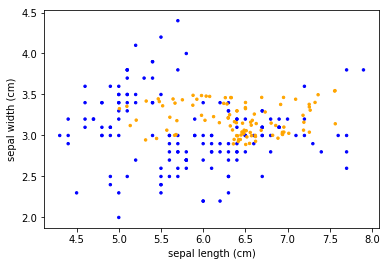

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure()
data_combined = pd.DataFrame(X_train, columns=feature_names)
data_combined['real_vs_fake'] = np.zeros(data_combined.shape[0])
data_combined = pd.concat((data_combined,fake_data ))
data_combined['real_vs_fake'] = data_combined['real_vs_fake'].astype(int)

# a scatter plot comparing num_children and num_pets
x1 = data_combined['sepal length (cm)']
y1 = data_combined['sepal width (cm)']
c = ['orange' if val==1 else 'blue' for val in data_combined['real_vs_fake']]
plt.scatter(x1, y1, c=c, label=c, s=6)

plt.xlabel('sepal length (cm)')
plt.ylabel('sepal width (cm)')
#plt.legend()
plt.show()